# Decoding Surface Code

In this experiment, we’ll use ``mdopt`` to decode the Surface Code. Hereafter, we assume an independent noise model as well as perfect syndrome measurements. We will create a Surface Code instance via the Hypergraph Product of two repetition codes. This example will be less pedagogical than the one with the Shor's code because we have already packaged all subroutines in a function. For a detailed overview of these subroutines the user is invited to read the Shor Code example as well as consult the appropriate code.

In [1]:
import numpy as np
from tqdm import tqdm
import qecstruct as qc
from scipy.stats import sem
import qecsim.paulitools as pt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bitflip_bias,
    css_code_stabilisers,
    plot_parity_check_mpo,
    multiply_pauli_strings,
)
from examples.decoding.decoding import (
    decode_css,
    pauli_to_mps,
    css_code_checks,
    css_code_logicals,
    css_code_stabilisers,
    css_code_logicals_sites,
    css_code_constraint_sites,
    generate_pauli_error_string,
)

In [2]:
LATTICE_SIZE = 3
rep_code = qc.repetition_code(LATTICE_SIZE)
surface_code = qc.hypergraph_product(rep_code, rep_code)

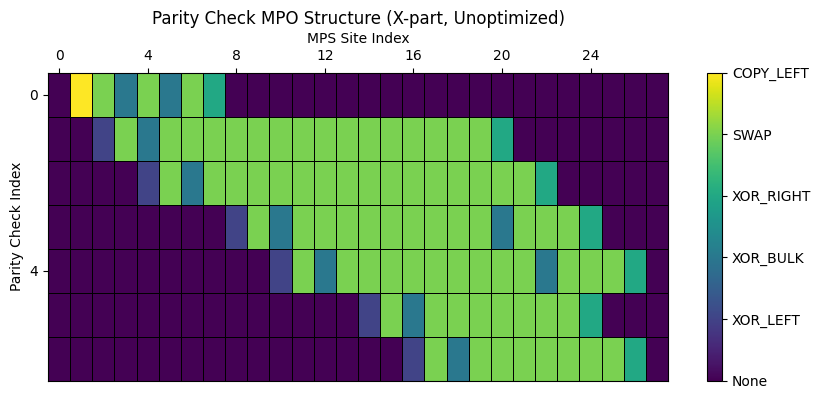

In [3]:
mpo_matrix = plot_parity_check_mpo(
    surface_code, optimize_order=False, return_matrix=True, plot_type="X"
)

In [4]:
LATTICE_SIZE = 3
NUM_QUBITS = 2 * (LATTICE_SIZE - 1) * LATTICE_SIZE
NUM_EXPERIMENTS = 10

SEED = 123
seed_seq = np.random.SeedSequence(SEED)
errors = {}

max_bond_dims = [64, 32, 16, 8, 4, 2]
error_rates = np.linspace(0.05, 0.20, 11)
failures_statistics = {}

rep_code = qc.repetition_code(LATTICE_SIZE)
surface_code = qc.hypergraph_product(rep_code, rep_code)

for CHI_MAX in max_bond_dims:
    print(f"CHI_MAX = {CHI_MAX}")
    for ERROR_RATE in tqdm(error_rates):
        failures = []
        errors[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = []

        for l in range(NUM_EXPERIMENTS):
            new_seed = seed_seq.spawn(1)[0]
            rng = np.random.default_rng(new_seed)
            random_integer = rng.integers(1, 10**8 + 1)
            SEED = random_integer

            error = generate_pauli_error_string(
                len(surface_code),
                ERROR_RATE,
                seed=SEED,
                error_model="Bit Flip",
            )
            errors[LATTICE_SIZE, CHI_MAX, ERROR_RATE].append(error)

            _, success = decode_css(
                code=surface_code,
                error=error,
                chi_max=CHI_MAX,
                multiply_by_stabiliser=True,
                bias_type="Bit Flip",
                bias_prob=0.05,
                renormalise=True,
                silent=True,
                contraction_strategy="Optimised",
            )

            failures.append(1 - success)

        failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = failures

CHI_MAX = 64


100%|██████████| 11/11 [00:30<00:00,  2.80s/it]


CHI_MAX = 32


100%|██████████| 11/11 [00:12<00:00,  1.11s/it]


CHI_MAX = 16


100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


CHI_MAX = 8


100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


CHI_MAX = 4


 45%|████▌     | 5/11 [00:01<00:01,  4.44it/s]/Users/aleksandrberezutskii/mdopt/mdopt/mps/canonical.py:274: RuntimeWarning: invalid value encountered in divide
  dense /= np.linalg.norm(dense, ord=norm)
100%|██████████| 11/11 [00:02<00:00,  4.20it/s]


CHI_MAX = 2


100%|██████████| 11/11 [00:02<00:00,  4.23it/s]


In [6]:
errors[3, 64, 0.05]

['IIIIIIIIIIIIX',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'XIXIIXIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIXIIX',
 'IIIIIXIIIIIII',
 'IIIIIIIIIIIII']

In [7]:
errors[3, 32, 0.05]

['IXXIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IXIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IXIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IIIIIIIIIIIII',
 'IXIIIIIIIIIII']

In [5]:
failure_rates = {}
error_bars = {}

for CHI_MAX in max_bond_dims:
    for ERROR_RATE in error_rates:
        failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = np.mean(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )
        error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] = sem(
            failures_statistics[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
        )

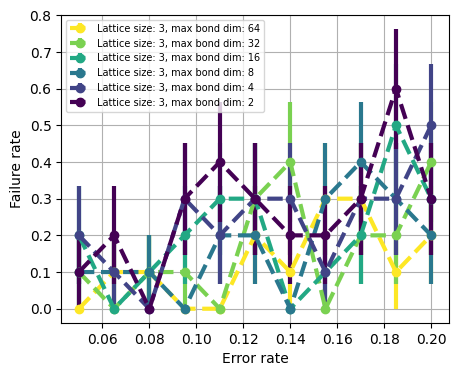

In [6]:
plt.figure(figsize=(5, 4))

green_cmap = matplotlib.colormaps["viridis_r"]
norm = Normalize(vmin=0, vmax=len(max_bond_dims) - 1)

for index, CHI_MAX in enumerate(max_bond_dims):
    plt.errorbar(
        error_rates,
        [
            failure_rates[LATTICE_SIZE, CHI_MAX, ERROR_RATE]
            for ERROR_RATE in error_rates
        ],
        yerr=[
            error_bars[LATTICE_SIZE, CHI_MAX, ERROR_RATE] for ERROR_RATE in error_rates
        ],
        fmt="o--",
        label=f"Lattice size: {LATTICE_SIZE}, max bond dim: {CHI_MAX}",
        linewidth=3,
        color=green_cmap(norm(index)),
    )

# plt.yscale("log")
plt.legend(fontsize=7)
plt.xlabel("Error rate")
plt.ylabel("Failure rate")
plt.grid()

plt.show()

In [ ]:
LATTICE_SIZE = 3
NUM_EXPERIMENTS = 100
SEED = 123
seed_seq = np.random.SeedSequence(SEED)

BOND_DIM = 64
ERROR_RATE = 0.01

rep_code = qc.repetition_code(LATTICE_SIZE)
surface_code = qc.hypergraph_product(rep_code, rep_code)
stabilisers_x, stabilisers_z = css_code_stabilisers(surface_code)
stabilisers = stabilisers_x + stabilisers_z

errors = []
failures = []

for l in tqdm(range(NUM_EXPERIMENTS)):
    new_seed = seed_seq.spawn(1)[0]
    rng = np.random.default_rng(new_seed)
    random_integer = rng.integers(1, 10**8 + 1)
    SEED = random_integer

    error = generate_pauli_error_string(
        len(surface_code),
        ERROR_RATE,
        seed=SEED,
        error_model="Depolarising",
    )
    error = multiply_pauli_strings(error, np.random.choice(stabilisers))
    errors.append(error)
    error = pauli_to_mps(error)

    _, success = decode_css(
        code=surface_code,
        error=error,
        chi_max=CHI_MAX,
        bias_type="Depolarising",
        bias_prob=0.01,
        renormalise=True,
        silent=True,
        contraction_strategy="Optimised",
    )

    failures.append(1 - success)

In [ ]:
failures[7]

In [ ]:
errors[7]

In [ ]:
import logging
from functools import reduce
from typing import cast, Union, Optional, List, Tuple

import numpy as np
from tqdm import tqdm
from matrex import msro
from opt_einsum import contract
from more_itertools import powerset
from qecstruct import (
    BinarySymmetricChannel,
    BinaryVector,
    LinearCode,
    CssCode,
    Rng,
)

from mdopt.mps.explicit import ExplicitMPS
from mdopt.mps.canonical import CanonicalMPS
from mdopt.mps.utils import (
    marginalise,
    inner_product,
    find_orth_centre,
    create_simple_product_state,
    create_custom_product_state,
)
from mdopt.contractor.contractor import apply_one_site_operator, mps_mpo_contract
from mdopt.optimiser.utils import XOR_LEFT, XOR_BULK, XOR_RIGHT, COPY_LEFT, SWAP
from mdopt.optimiser.dephasing_dmrg import DephasingDMRG
from mdopt.utils.utils import split_two_site_tensor
from mdopt.optimiser.utils import ConstraintString
from examples.decoding.decoding import (
    apply_depolarising_bias,
    apply_constraints,
    apply_bitflip_bias,
)

In [ ]:
LATTICE_SIZE = 3
rep_code = qc.repetition_code(LATTICE_SIZE)
code = qc.hypergraph_product(rep_code, rep_code)
stabilisers_x, stabilisers_z = css_code_stabilisers(surface_code)
stabilisers = stabilisers_x + stabilisers_z

# error = 'IIXIIXIIIIXII'
error = generate_pauli_error_string(
    len(surface_code),
    0.3,
    seed=123,
    error_model="Depolarising",
)
print(error)
error = pauli_to_mps(error)

In [ ]:
for size in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    rep_code = qc.repetition_code(size)
    code = qc.hypergraph_product(rep_code, rep_code)
    print(len(code))

In [ ]:
num_sites = 2 * len(code) + code.num_x_logicals() + code.num_z_logicals()
num_logicals = code.num_x_logicals() + code.num_z_logicals()

In [ ]:
logicals_state = "+" * num_logicals
state_string = logicals_state + error
error_mps = create_custom_product_state(string=state_string)

In [ ]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

In [ ]:
constraints_sites = css_code_constraint_sites(code)
logicals_sites = css_code_logicals_sites(code)
sites_to_bias = list(range(num_logicals, num_sites))

In [ ]:
error_mps = apply_depolarising_bias(
    mps=error_mps,
    sites_to_bias=sites_to_bias,
    prob_bias_list=0.1,
    renormalise=True,
)

In [ ]:
error_mps = apply_constraints(
    error_mps,
    constraints_sites[0],
    constraints_tensors,
    chi_max=CHI_MAX,
    renormalise=True,
    silent=False,
    strategy="Optimised",
    result_to_explicit=False,
)

In [ ]:
error_mps = apply_constraints(
    error_mps,
    constraints_sites[1],
    constraints_tensors,
    chi_max=CHI_MAX,
    renormalise=True,
    silent=False,
    strategy="Optimised",
    result_to_explicit=False,
)

In [ ]:
error_mps = apply_constraints(
    error_mps,
    logicals_sites,
    logicals_tensors,
    chi_max=CHI_MAX,
    renormalise=True,
    silent=False,
    strategy="Optimised",
    result_to_explicit=False,
)

In [ ]:
sites_to_marginalise = list(range(num_logicals, len(error) + num_logicals))
logical_mps = marginalise(
    mps=error_mps,
    sites_to_marginalise=sites_to_marginalise,
)

In [ ]:
logical_mps.dense(flatten=True, renormalise=True, norm=1)